This tutorial demonstrates how to generate a particle_reader in Relion using `cryojax`. This tutorial builds upon tools already shown in other tutorials, so we might skip over some details.

In [1]:
%load_ext autoreload
%autoreload 2

First we will do all the imports required to run the tutorial

In [2]:
# Jax and Equinox imports
from functools import partial

import equinox as eqx
import jax
import jax.numpy as jnp
from jaxtyping import PRNGKeyArray

In [3]:
# Plotting imports and functions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [4]:
# CryoJAX imports

import cryojax.simulator as cxs
from cryojax.data import (
    RelionParticleImageReader,
    RelionParticleParameterReader,
    RelionParticleParameters,
    write_simulated_image_stack_from_starfile,
    write_starfile_with_particle_parameters,
)
from cryojax.image import operators as op
from cryojax.io import read_atoms_from_pdb
from cryojax.rotations import SO3

# Generating a starfile

We have split this tutorial in two parts. In the first part we will generate a starfile, but we will not generate any particles. In the second part we will show how to generate particles from a starfile, and how to save such particles to the respective MRC Files.

We have decided to keep this two steps separate for a simple reason, flexibility. We want to make it possible for every user to design their own image formation pipeline. In some of our other tutorials we have showed how to generate noiseless image, images with solvent noise, or images with noise coming from a distribution. You can easily adapt this tutorial to those cases, or any other pipeline you build.

Now we will start by generating a starfile. To do this, we will first create a cryojax RelionParticleParameterReader.

In this function we vmap over `jax` random keys. You can adapt this function to your needs, such as adapting the range of the distributions for the random parameters, or changing wheter a parameter is random or not.

In [5]:
# @partial(eqx.filter_vmap, in_axes=(0, None), out_axes=(eqx.if_array(0), None))
@partial(eqx.filter_vmap, in_axes=(0, None))
def make_particle_parameters(
    key: PRNGKeyArray, instrument_config: cxs.InstrumentConfig
):  # -> tuple[RelionParticleParameters, RelionParticleParameters]:
    # Generate random parameters

    # Pose
    # ... instantiate rotations

    key, subkey = jax.random.split(key)  # split the key to use for the next random number

    rotation = SO3.sample_uniform(subkey)
    key, subkey = jax.random.split(key)  # do this everytime you use a key!!

    # ... now in-plane translation
    ny, nx = instrument_config.shape
    offset_in_angstroms = (
        jax.random.uniform(subkey, (2,), minval=-0.2, maxval=0.2)
        * jnp.asarray((nx, ny))
        * instrument_config.pixel_size
    )
    # ... build the pose
    pose = cxs.EulerAnglePose.from_rotation_and_translation(rotation, offset_in_angstroms)

    # CTF Parameters
    # ... defocus
    defocus_in_angstroms = jax.random.uniform(subkey, (), minval=1000, maxval=1500)
    key, subkey = jax.random.split(key)

    astigmatism_in_angstroms = jax.random.uniform(subkey, (), minval=0, maxval=100)
    key, subkey = jax.random.split(key)

    astigmatism_angle = jax.random.uniform(subkey, (), minval=0, maxval=jnp.pi)
    key, subkey = jax.random.split(key)

    phase_shift = jax.random.uniform(subkey, (), minval=0, maxval=0)
    # no more random numbers needed

    # now generate your non-random values
    spherical_aberration_in_mm = 2.7
    amplitude_contrast_ratio = 0.1
    b_factor = 0.0
    ctf_scale_factor = 1.0

    # ... build the CTF
    transfer_theory = cxs.ContrastTransferTheory(
        ctf=cxs.ContrastTransferFunction(
            defocus_in_angstroms=defocus_in_angstroms,
            astigmatism_in_angstroms=astigmatism_in_angstroms,
            astigmatism_angle=astigmatism_angle,
            spherical_aberration_in_mm=spherical_aberration_in_mm,
            amplitude_contrast_ratio=amplitude_contrast_ratio,
            phase_shift=phase_shift,
        ),
        envelope=op.FourierGaussian(b_factor=b_factor, amplitude=ctf_scale_factor),
    )

    relion_particle_parameters = RelionParticleParameters(
        instrument_config=instrument_config,
        pose=pose,
        transfer_theory=transfer_theory,
    )

    return relion_particle_parameters
    # filter_spec = get_filter_spec(
    #     relion_particle_parameters,
    #     lambda x: (
    #         x.instrument_config.voltage_in_kilovolts,
    #         x.instrument_config.pixel_size,
    #         x.transfer_theory.ctf.amplitude_contrast_ratio,
    #         x.transfer_theory.ctf.spherical_aberration_in_mm,
    #     ),
    #     inverse=True,
    # )
    # return eqx.partition(relion_particle_parameters, filter_spec)

In [6]:
# Generate instrument config
instrument_config = cxs.InstrumentConfig(
    shape=(128, 128),
    pixel_size=1.5,
    voltage_in_kilovolts=300.0,
    pad_scale=1.0,  # no padding
)

# Generate RNG keys
number_of_images = 100
keys = jax.random.split(jax.random.PRNGKey(0), number_of_images)

# ... instantiate the RelionParticleParameterReader
# particle_parameters_vmap, particle_parameters_novmap = make_particle_parameters(
#     keys, instrument_config
# )

particle_parameters = make_particle_parameters(keys, instrument_config)

To see the values of any particular parameter, you can do

Lastly, we can easily generate the starfile from the built-in `cryojax.data.write_starfile_with_particle_parameters` function.

The `mrc_batch_size` parameter let's you specify how many particles you want per mrcfile.

In this case we will place 50 images per mrcfile, giving us two mrcfiles.

In [7]:
# ... generate the starfile
# particle_parameters = eqx.combine(particle_parameters_vmap, particle_parameters_novmap)
write_starfile_with_particle_parameters(
    particle_parameters, "./relion_dataset.star", mrc_batch_size=50, overwrite=True
)

# Simulating particles based on a starfile and writing them to mrcs

Now we will see how to define the functions required for our `write_simulated_image_stack_from_starfile` function to work.

First, let's define our potential and let's load the starfile

## Simulating noiseless images

First, we will generate a stack without noise using one of `cryojax` imaging pipelines.

In [8]:
# First load the starfile

path_to_mrc_files = "./relion_dataset_particles/noiseless"

parameter_reader = RelionParticleParameterReader(
    path_to_starfile="./relion_dataset.star",  # starfile we created
    path_to_relion_project=path_to_mrc_files,  # here is where the mrcs will be saved
    get_envelope_function=True,
)

!!! info "For more information on reading data in RELION, check our `Read a particle stack` tutorial."

Now let's define the structure we will use to generate images. In this case, we show how to load a pdb and then turn it into a voxel grid. We all need to define how we will integrate our potential.

In [9]:
filename = "./data/groel_chainA.pdb"
atom_positions, atom_identities, b_factors = read_atoms_from_pdb(
    filename, center=True, select="not element H", get_b_factors=True
)
atomic_potential = cxs.PengAtomicPotential(atom_positions, atom_identities, b_factors)

# get values from the "optics" datablock in the starfile
box_size = parameter_reader[0].instrument_config.shape[0]
voxel_size = parameter_reader[0].instrument_config.pixel_size

real_voxel_grid = atomic_potential.as_real_voxel_grid(
    shape=(box_size, box_size, box_size), voxel_size=voxel_size
)
potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=2
)

potential_integrator = cxs.FourierSliceExtraction(interpolation_order=1)

Now we will build a function that generates an imaging pipeline from the parameter reader

In [10]:
from typing import Any


def build_imaging_pipeline_from_particle_parameters(
    relion_particle_parameters: RelionParticleParameters,
    args: Any,
) -> cxs.ContrastImagingPipeline:
    potential, potential_integrator = args

    structural_ensemble = cxs.SingleStructureEnsemble(
        potential, relion_particle_parameters.pose
    )

    scattering_theory = cxs.WeakPhaseScatteringTheory(
        structural_ensemble,
        potential_integrator,
        relion_particle_parameters.transfer_theory,
    )
    imaging_pipeline = cxs.ContrastImagingPipeline(
        relion_particle_parameters.instrument_config, scattering_theory
    )
    return imaging_pipeline

and a function that simply computes images from relion particle parameters. They don't really need to be in separate functions.

In [11]:
def compute_image(
    relion_particle_parameters: RelionParticleParameters,
    args: Any,
):
    imaging_pipeline = build_imaging_pipeline_from_particle_parameters(
        relion_particle_parameters, args
    )
    return imaging_pipeline.render()

In [12]:
type(parameter_reader[0])

cryojax.data._relion._starfile_reading.RelionParticleParameters

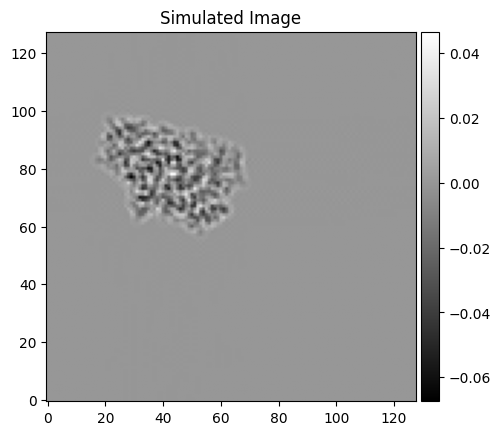

In [13]:
image = compute_image(parameter_reader[0], (potential, potential_integrator))
plot_image(image, plt.figure(), plt.gca(), label="Simulated Image");

Finally, we can use this function to write a particle stack!

In [14]:
args = (potential, potential_integrator)  # the args compute_image takes

write_simulated_image_stack_from_starfile(
    parameter_reader=parameter_reader,
    compute_image=compute_image,
    args=args,
    is_jittable=True,
    batch_size_per_mrc=10,
    seed=None,
    overwrite=True,
    compression=None,
)

!!! info "How does `write_simulated_image_stack_from_starfile` work?"

    The arguments to call this function are:

    - `parameter_reader`: needs to be an instance of `RelionParticleParameterReader`
    - `compute_image`: function that should take (RelionParticleParameters, args) or (jax.PRNGKey, RelionParticleParameters, args) as input
    - `args`: the args for `compute_image` function
    - `is_jittable`: whether or not your function can be jitted with `equinox.filter_jit`. (If you are not sure, run it and set it to False if it does not work)
    - `batch_size_per_mrc`: if your function is jittable we will vmap the computation of the images, which might have a big memory usage. If you get some "Ran out of memory" error, then adjust this batch size. Setting it to "None" will assume no batching needs to be done. Setting it to 1 runs the code in serial mode.
    - `seed`: a seed for generating noise (Optional)
    - `overwrite`: whether or not you want existing files to be overwritten.
    - `compression`: mrcfile compression, see the `mrcfile` library docs for more information.

    If you add a seed, then `compute_image` should take a `jax.random.PRNGKey` as its first argument (next example), which is needed to generate a sample of the noise from whatever distribution you define.

    Inside our code we will call your `compute_image` function to generate an image stack, and then save it as an mrcfile.

!!! info "For more information on imaging pipelines check the `Simulate an image` tutorial."

## Simulating images with a noise distribution

In this example we will use a cryojax distribution to add the noise, but in practice you can do it however you want.

We need a different dataset, as we will save these images in a different folder

In [15]:
# First load the starfile

path_to_mrc_files = "./relion_dataset_particles/with_noise"

parameter_reader_for_noise_images = RelionParticleParameterReader(
    path_to_starfile="./relion_dataset.star",  # starfile we created
    path_to_relion_project=path_to_mrc_files,  # here is where the mrcs will be saved
    get_envelope_function=True,
)

the other parameters do not change, so there is no need to initialize them again.

We will follow a simular approach as before. First, let's write a function that generates a distribution from a `RelionParticleParameters`:

In [16]:
from cryojax.inference import distributions as dist


def build_distribution_from_relion_particle_parameters(
    relion_particle_parameters: RelionParticleParameters,
    args: Any,
) -> dist.IndependentGaussianFourierModes:
    potential, potential_integrator = args

    structural_ensemble = cxs.SingleStructureEnsemble(
        potential, relion_particle_parameters.pose
    )

    scattering_theory = cxs.WeakPhaseScatteringTheory(
        structural_ensemble,
        potential_integrator,
        relion_particle_parameters.transfer_theory,
    )
    imaging_pipeline = cxs.ContrastImagingPipeline(
        relion_particle_parameters.instrument_config, scattering_theory
    )
    distribution = dist.IndependentGaussianFourierModes(
        imaging_pipeline,
        signal_scale_factor=jnp.sqrt(instrument_config.n_pixels),
        variance_function=op.Constant(1.0),
    )
    return distribution

and a function that generates an image

In [17]:
def compute_image_with_noise(
    key: PRNGKeyArray,
    relion_particle_parameters: RelionParticleParameters,
    args: Any,
):
    distribution = build_distribution_from_relion_particle_parameters(
        relion_particle_parameters, args
    )
    return distribution.sample(key)

and generate an image from such distribution

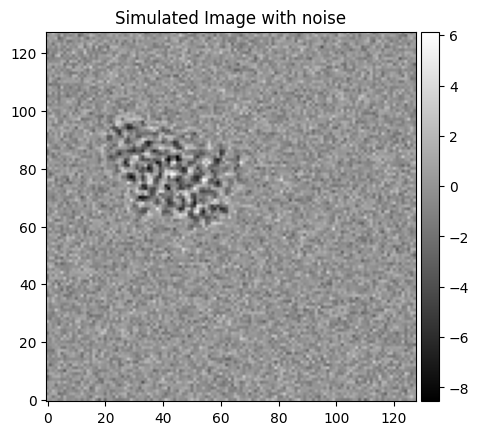

In [18]:
key = jax.random.key(0)

image_with_noise = compute_image_with_noise(
    key, parameter_reader_for_noise_images[0], (potential, potential_integrator)
)
plot_image(image_with_noise, plt.figure(), plt.gca(), label="Simulated Image with noise");

Lastly, let's generate a stack with noise

In [19]:
args = (potential, potential_integrator)  # the args compute_image takes

write_simulated_image_stack_from_starfile(
    parameter_reader_for_noise_images,
    compute_image_with_noise,
    args,
    seed=0,
    overwrite=True,
)

/Data/Packages/Utilities/VirtualEnvs/cryojax-env/lib/python3.13/site-packages/mrcfile/mrcobject.py:626: RuntimeWarning: Data array contains NaN values
  warnings.warn("Data array contains NaN values", RuntimeWarning)
/Data/Packages/Utilities/VirtualEnvs/cryojax-env/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Data/Packages/Utilities/VirtualEnvs/cryojax-env/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Data/Packages/Utilities/VirtualEnvs/cryojax-env/lib/python3.13/site-packages/numpy/_core/_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/Data/Packages/Utilities/VirtualEnvs/cryojax-env/lib/python3.13/site-packages/numpy/_core/_methods.py:171: RuntimeWarning: inv

Now we can load our images using `RelionParticleImagesReader`s

In [20]:
particle_reader_noiseless = RelionParticleImageReader(parameter_reader)

particle_reader_noisy = RelionParticleImageReader(parameter_reader_for_noise_images)

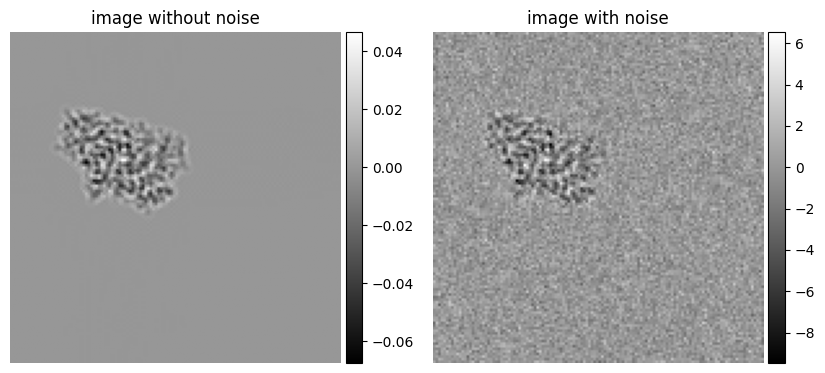

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for a in ax:
    a.set_axis_off()

im1 = plot_image(
    particle_reader_noiseless[0].image_stack,
    fig,
    ax[0],
    label="image without noise",
)

im2 = plot_image(
    particle_reader_noisy[0].image_stack,
    fig,
    ax[1],
    label="image with noise",
)